In [4]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch 

import pickle
from kg import KnowledgeGraph

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

print('Using Device:', device) 

Using Device: cuda


In [6]:
## Add node indices
## nodes_df: Dataframe containing node information with columns: node_idx, node_id, node_type
## relations_df: Dataframe containing relation information with columns: source ID/type, target ID/type

def add_node_indices(nodes_df, relations_df):
    """
    Add node indices from nodes dataframe to relations dataframe based on ID and type matching.
    
    Args:
    	nodes_df (pd.DataFrame): Dataframe containing node information with columns: node_idx, node_id, node_type
    	relations_df (pd.DataFrame): Dataframe containing relation information with columns: x_id, x_type, y_id, y_type
   
    Returns:
    	pd.DataFrame: Filtered relations dataframe with added x_idx, y_idx, and included columns
    """
    # Create a copy of the relations dataframe to avoid modifying the original
    result_df = relations_df.copy()
    
    # Convert node_id to string type in nodes_df for consistent matching
    nodes_df = nodes_df.copy()
    nodes_df['node_id'] = nodes_df['node_id'].astype(str)
    
    # Convert x_id and y_id to string type in relations_df
    result_df['x_id'] = result_df['x_id'].astype(str)
    result_df['y_id'] = result_df['y_id'].astype(str)
    
    # Create a mapping dictionary from (node_id, node_type) to node_idx
    node_mapping = pd.Series(
        nodes_df.node_idx.values,
        index=pd.MultiIndex.from_arrays([nodes_df.node_id, nodes_df.node_type])
    ).to_dict()
    
    # Create a function to safely get mapping value
    def get_mapping(row, id_col, type_col):
        key = (row[id_col], row[type_col])
        return node_mapping.get(key)
    
    # Add x_idx column by mapping (x_id, x_type)
    result_df['x_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'x_id', 'x_type'), 
        axis=1
    )
    
    # Add y_idx column by mapping (y_id, y_type)
    result_df['y_idx'] = result_df.apply(
        lambda row: get_mapping(row, 'y_id', 'y_type'), 
        axis=1
    )
    
    # Check if both indices are valid (not NaN) and add 'included' column
    result_df['included'] = result_df['x_idx'].notna() & result_df['y_idx'].notna()
    
    # Filter rows where both x_idx and y_idx are not NaN
    result_df = result_df[result_df['included']].copy()
    
    # Convert x_idx and y_idx to integers
    result_df['x_idx'] = result_df['x_idx'].astype(int)
    result_df['y_idx'] = result_df['y_idx'].astype(int)
    
    return result_df


data_dir = os.environ.get('DATA_DIR', './Data')
output_dir = os.environ.get('OUTPUT_DIR', './Output')

df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')
print("Loading HPO to index dictionary...")

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/hpo_to_idx_dict_8.9.21_kg.pkl', 'rb') as f:
    hpo_to_idx_dict = pickle.load(f)

print("Loading Genes to index dictionary...")
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/ensembl_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    genes = pickle.load(file)

with open(f'{data_dir}/preprocess/orphanet/orphanet_to_mondo_dict.pkl', 'rb') as file:
        orphanet_to_mondo_dict = pickle.load(file)

with open(f'{data_dir}/knowledge_graph/8.9.21_kg/mondo_to_idx_dict_8.9.21_kg.pkl', 'rb') as file:
    mondo_to_idx_dict = pickle.load(file)

# create_nodes_pkl(data_dir)
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

/tmp/ipykernel_1617619/2845939711.py:66: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')


Loading HPO to index dictionary...
Loading Genes to index dictionary...


In [7]:
# The nodes_8.9.21_kg.pkl file contains node information with columns: node_idx, node_id, node_type
with open(f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl', 'rb') as file:
    nodes = pickle.load(file)

print("\nFirst 5 rows of the data:")
print(nodes.head(5),"\n")
print("there are:",nodes.shape[0],"of nodes \n")
print(nodes['node_type'].value_counts())


First 5 rows of the data:
   node_idx node_id     node_type        node_name node_source old_node_name
0         0    9796  gene/protein  ENSG00000168490        NCBI        PHYHIP
1         1    7918  gene/protein  ENSG00000204438        NCBI        GPANK1
2         2    8233  gene/protein  ENSG00000169249        NCBI         ZRSR2
3         3    4899  gene/protein  ENSG00000106459        NCBI          NRF1
4         4    5297  gene/protein  ENSG00000241973        NCBI         PI4KA 

there are: 105220 of nodes 

node_type
biological_process    28642
gene/protein          21610
disease               21233
effect/phenotype      15874
molecular_function    11169
cellular_component     4176
pathway                2516
Name: count, dtype: int64


In [8]:
# the kg_giant_orphanet.csv file contains the relationships between nodes with columns
# this is the predefined relationships between nodes
df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')

print("\nFirst 5 rows of relationships:")
print(df.head(5), "\n")
print("there are:",df.shape[0],"of relationships \n")
print(df['relation'].value_counts())


/tmp/ipykernel_1617619/3825346476.py:3: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}/knowledge_graph/8.9.21_kg/kg_giant_orphanet.csv')



First 5 rows of relationships:
          relation display_relation  x_id        x_type  x_name x_source  \
0  protein_protein              ppi  9796  gene/protein  PHYHIP     NCBI   
1  protein_protein              ppi  7918  gene/protein  GPANK1     NCBI   
2  protein_protein              ppi  8233  gene/protein   ZRSR2     NCBI   
3  protein_protein              ppi  4899  gene/protein    NRF1     NCBI   
4  protein_protein              ppi  5297  gene/protein   PI4KA     NCBI   

    y_id        y_type  y_name y_source  
0  56992  gene/protein   KIF15     NCBI  
1   9240  gene/protein   PNMA1     NCBI  
2  23548  gene/protein   TTC33     NCBI  
3  11253  gene/protein  MAN1B1     NCBI  
4   8601  gene/protein   RGS20     NCBI   

there are: 5471882 of relationships 

relation
drug_drug                     2672628
protein_present_anatomy       1518203
protein_protein                321075
disease_phenotype_positive     204779
protein_bioprocess             144805
disease_protein     

In [9]:
# View some HPO indices
print("Sample HPO indices:")
print(list(hpo_to_idx_dict.items())[:5])

# View some gene indices
print("\nSample gene indices:")
print(list(genes.items())[:5])

# View some disease indices
print("\nSample disease indices:")
print(list(mondo_to_idx_dict.items())[:5])

Sample HPO indices:
[('HP:0002240', 14012), ('HP:0001254', 14013), ('HP:0010547', 14014), ('HP:0001252', 14015), ('HP:0001250', 14016)]

Sample gene indices:
[('ENSG00000168490', 0), ('ENSG00000204438', 1), ('ENSG00000169249', 2), ('ENSG00000106459', 3), ('ENSG00000241973', 4)]

Sample disease indices:
[('13924', 19687), ('11160', 19688), ('8099', 19689), ('14854', 19690), ('33202', 19691)]


In [10]:
## enriched information about the nodes and their relationships
## output: result.csv, after mapping the relationship into nodes, we built the knowledge graph
result = add_node_indices(nodes, df)
result.to_csv(f'{output_dir}/result.csv', index=False)


In [11]:
## Generate and construct the knowledge graph

## Initialize KG
kg = KnowledgeGraph()

## Chucksize is the size of knowledge graph data to be loaded at once
kg.create_from_csv(
    filepath=f'./{output_dir}/result.csv',
    nodes_filepath = f'{data_dir}/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl',
    chunksize=105220,  # Adjust based on your memory constraints
    show_progress=True
)

# Save the graph
## This is the knowledge graph
kg.save_graph(f'{output_dir}/my_graph_ids.graphml')


# # code to double check the KG 
# subgraph = kg.plot_random_subgraph(num_nodes=10000, method='random_walk')

Loading nodes from ./Data/knowledge_graph/8.9.21_kg/nodes_8.9.21_kg.pkl
Loaded 105,220 nodes
Node columns: ['node_idx', 'node_id', 'node_type', 'node_name', 'node_source', 'old_node_name']
Loading relationships from Output/result.csv
Processed 1 chunks (105,220 rows)
Current graph size: 105,220 nodes, 105,220 edges
Number of node types: 7


/kai/Kai_Backup/Study/GiG in rare diease detection/kg.py:588: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk_num, chunk in enumerate(pd.read_csv(filepath, chunksize=chunksize)):


Processed 11 chunks (1,157,420 rows)
Current graph size: 105,220 nodes, 1,095,378 edges
Number of node types: 7

Finished loading 1,157,420 relationship rows
Total nodes from pickle file: 105,220
Total unique node types: 7

=== Knowledge Graph Summary ===
Nodes: 105,220
Edges: 1,095,378
Density: 0.000198
Average Degree: 20.82
Connected Components: 56

Node Types Distribution:
  biological_process: 28,642
  cellular_component: 4,176
  disease: 21,233
  effect/phenotype: 15,874
  gene/protein: 21,610
  molecular_function: 11,169
  pathway: 2,516

Edge Types Distribution:
  bioprocess_bioprocess: 52,886
  cellcomp_cellcomp: 4,845
  disease_disease: 35,167
  disease_phenotype_negative: 1,483
  disease_phenotype_positive: 204,779
  disease_protein: 86,299
  molfunc_molfunc: 13,574
  pathway_pathway: 2,535
  phenotype_phenotype: 21,925
  phenotype_protein: 10,518
  protein_bioprocess: 144,805
  protein_cellcomp: 83,402
  protein_molfunc: 69,530
  protein_pathway: 42,646
  protein_protein: 32

In [12]:
# # # Initialize KG
kg = KnowledgeGraph()
kg.load_graph(f'{output_dir}/my_graph_ids.graphml') #!!!!!!! if u want proper plotting u need to save and then load the graph, not work directly after creation the kg 

In [13]:
# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [
    [genes[g] for g in p['true_genes']]
    for p in val_data
]


# WORKING with PATINIET DATA
print('Loading and processing patient data...')
file_path = f'{data_dir}/patients/simulated_patients/disease_split_val_sim_patients_8.9.21_kg.txt'  # val data!!!!
with open(file_path, 'r') as f:
    val_data = [json.loads(line) for line in f]

file_path = f'{data_dir}/patients/simulated_patients/disease_split_train_sim_patients_8.9.21_kg.txt'  # train data!!!!
with open(file_path, 'r') as f:
    train_data = [json.loads(line) for line in f]


## Map the phenotype to the index
val_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in val_data]
train_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in train_data]


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(val_patients_phenotypes_list, f)

## Map genes to index
val_patients_genes = [[genes[g] for g in p['true_genes']] for p in val_data]
train_patients_genes = [[genes[g] for g in p['true_genes']] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(train_patients_phenotypes_list, f)


# Save the list to a pickle file
with open(f'{output_dir}/val_patients_genes.pkl', 'wb') as f:
    pickle.dump(val_patients_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_patients_genes.pkl', 'wb') as f:
    pickle.dump(train_patients_genes, f)

## Map the disease to the index
val_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in val_data]
train_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in train_data]

# Save the list to a pickle file
with open(f'{output_dir}/val_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(val_all_candidate_genes, f)

# Save the list to a pickle file
with open(f'{output_dir}/train_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(train_all_candidate_genes, f)

print("Saved patient_training and validation data")

## process test data
file_path = f'{data_dir}/patients/mygene2_patients/mygene2_5.7.22.txt'  # val data!!!!

with open(file_path, 'r') as f:
    test_data = [json.loads(line) for line in f]
    
test_patients_phenotypes_list = [[hpo_to_idx_dict[phenotype] for phenotype in p['positive_phenotypes']] for p in test_data]


# Save the list to a pickle file
with open(f'{output_dir}/test_patients_phenotypes_list.pkl', 'wb') as f:
    pickle.dump(test_patients_phenotypes_list, f)

test_patients_genes = [[genes[g] for g in p['true_genes']] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_patients_genes.pkl', 'wb') as f:
    pickle.dump(test_patients_genes, f)


test_all_candidate_genes = [[genes[g] for g in p['all_candidate_genes'] if g in genes] for p in test_data]

# Save the list to a pickle file
with open(f'{output_dir}/test_all_candidate_genes.pkl', 'wb') as f:
    pickle.dump(test_all_candidate_genes, f)

print("Saved patient_test data")

Loading and processing patient data...
Loading and processing patient data...
Saved patient_training and validation data
Saved patient_test data


In [14]:
# What in training data 
# True genes that cause specific diseases
# True symptoms
# True age of conset
# All candidate genes

train_data[0]

{'true_genes': ['ENSG00000146085'],
 'age': 'Onset_Infant',
 'positive_phenotypes': ['HP:0000124',
  'HP:0001249',
  'HP:0001254',
  'HP:0001259',
  'HP:0001252',
  'HP:0001510',
  'HP:0002017',
  'HP:0004374',
  'HP:0410042',
  'HP:0001903',
  'HP:0100806',
  'HP:0001279',
  'HP:0000712',
  'HP:0100739',
  'HP:0031009',
  'HP:0001363',
  'HP:0001360'],
 'negative_phenotypes': {'HP:0000083': ['init_phenotypes'],
  'HP:0001019': ['phenotype_distractor.9'],
  'HP:0002716': ['phenotype_distractor.9'],
  'HP:0002240': ['phenotype_distractor.9'],
  'HP:0000643': ['noisy_phenotype'],
  'HP:0001369': ['noisy_phenotype'],
  'HP:0008226': ['noisy_phenotype']},
 'n_distractor_genes': 11,
 'distractor_genes': ['ENSG00000143727',
  'ENSG00000014216',
  'ENSG00000158352',
  'ENSG00000105664',
  'ENSG00000197915',
  'ENSG00000157766',
  'ENSG00000188994',
  'ENSG00000095464',
  'ENSG00000132155',
  'ENSG00000152457',
  'ENSG00000168056'],
 'dropout_phenotypes': {'positive_phenotypes': ['HP:0001733',

In [15]:
# val_data[0]


In [16]:
# test_data[0]

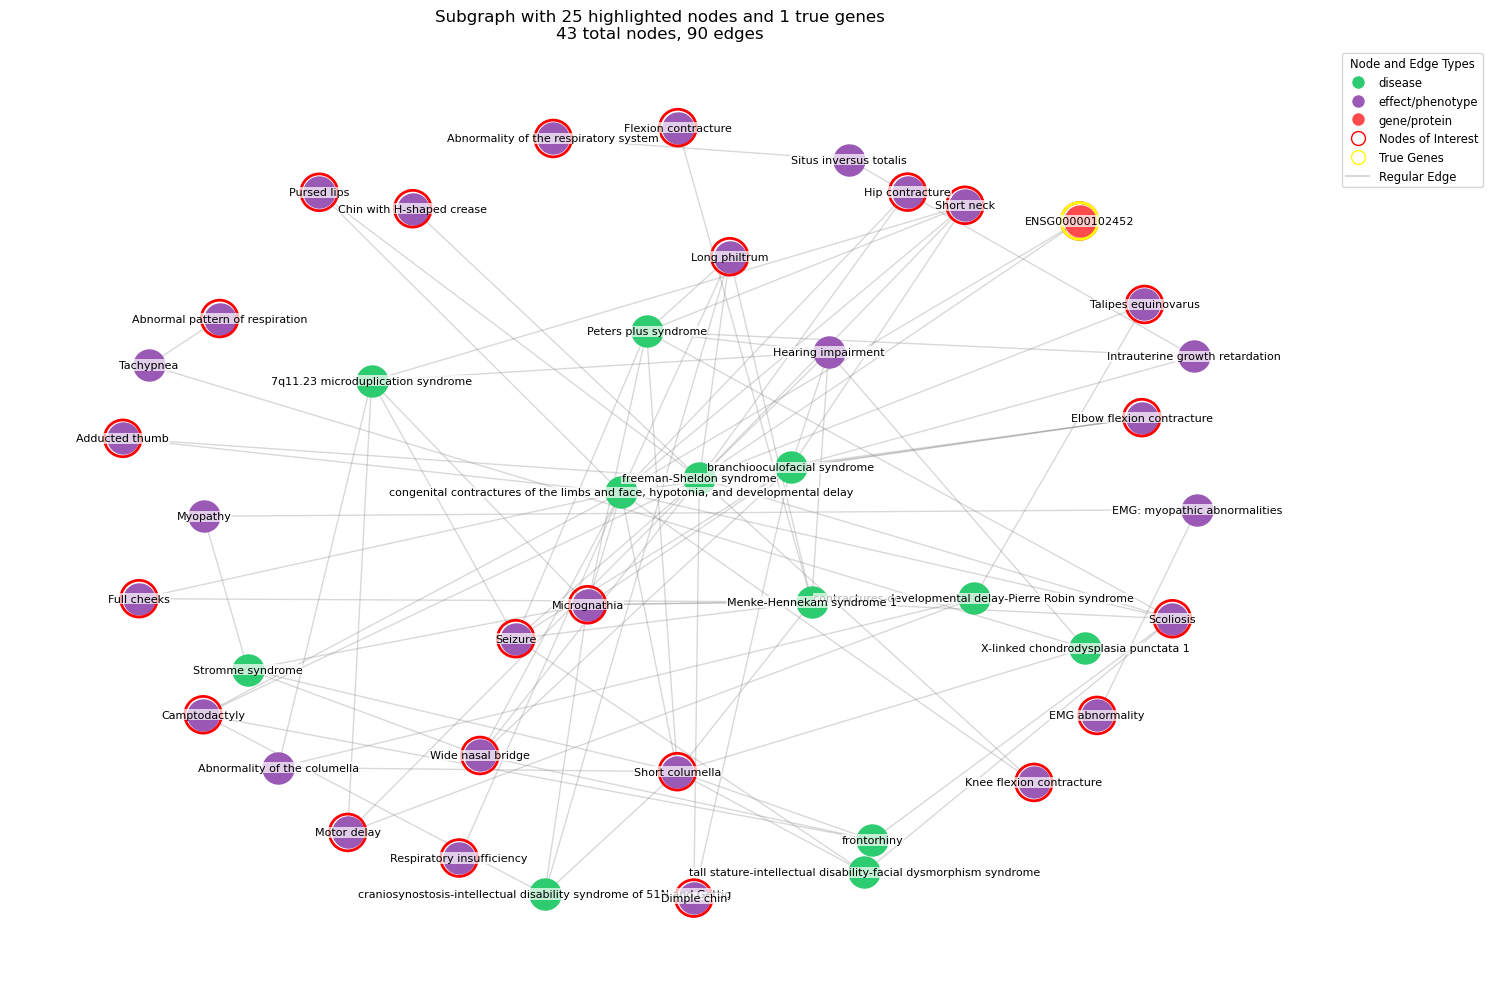

In [17]:
## Plot out the test data
## The grpah shows the connection between the patient's phenotypes, the candidate genes and the true genes of test data

i=1

kg.visualize_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])

In [18]:
## To map the local id to global id
train_nx_subgraph = []
train_pg_subgraph = []

for i in range(len(train_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in train_patients_phenotypes_list[i] + train_all_candidate_genes[i] + train_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in train_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    train_nx_subgraph.append(subgraph)
    train_pg_subgraph.append(pg_graph)

In [19]:
print(train_pg_subgraph[0])
## x = 58 nodes, there are 7 types of nodes
## edge_index: 196 connections between nodes
## edge_attr: 15 types of the connections
## There are 36224 patients in the training data

Data(
  x=[58, 7],
  edge_index=[2, 196],
  edge_attr=[196, 15],
  node_mapping={
    9967=0,
    54643=1,
    15726=2,
    12554=3,
    19674=4,
    26552=5,
    14120=6,
    14013=7,
    1591=8,
    26446=9,
    988=10,
    15567=11,
    14594=12,
    28869=13,
    15279=14,
    729=15,
    5784=16,
    16340=17,
    54520=18,
    60332=19,
    24307=20,
    20079=21,
    27771=22,
    14923=23,
    15322=24,
    5925=25,
    15350=26,
    1604=27,
    20698=28,
    14016=29,
    25375=30,
    14744=31,
    14012=32,
    12980=33,
    10335=34,
    69662=35,
    51614=36,
    27869=37,
    51663=38,
    15274=39,
    14015=40,
    19172=41,
    14231=42,
    23595=43,
    12868=44,
    14430=45,
    395=46,
    14434=47,
    14138=48,
    14341=49,
    10649=50,
    20953=51,
    2491=52,
    19829=53,
    14042=54,
    4536=55,
    2448=56,
    3170=57,
  },
  node_names=[58],
  original_ids=[58],
  node_type_mapping={
    biological_process=0,
    cellular_component=1,
    disease=

In [20]:
val_nx_subgraph = []
val_pg_subgraph = []

for i in range(len(val_patients_phenotypes_list)):

    # Without patients
    subgraph = kg.create_subgraph([str(n) for n in val_patients_phenotypes_list[i]+ val_all_candidate_genes[i]+ val_patients_genes[i]], true_gene_ids = [str(k) for k in val_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    val_nx_subgraph.append(subgraph)
    val_pg_subgraph.append(pg_graph)

In [21]:
test_nx_subgraph = []
test_pg_subgraph = []

for i in range(len(test_patients_phenotypes_list)):
    subgraph = kg.create_subgraph([str(n) for n in test_patients_phenotypes_list[i] + test_all_candidate_genes[i] + test_patients_genes[i]], 
                                true_gene_ids=[str(k) for k in test_patients_genes[i]])
    pg_graph = kg.create_pyg_data_from_subgraph(subgraph)
    test_nx_subgraph.append(subgraph)
    test_pg_subgraph.append(pg_graph)

In [22]:
## To get the number of true gene
all_true_gene_ids = []

for patient in train_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

for patient in val_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)
    
for patient in test_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

unique_true_gene_ids = set(all_true_gene_ids)
print("the number of unique true gene ids is:",len(unique_true_gene_ids))

gene_id_mapping = {gene_id: idx for idx, gene_id in enumerate(unique_true_gene_ids)}
print(gene_id_mapping)


the number of unique true gene ids is: 2405
{4: 0, 10: 1, 8204: 2, 8208: 3, 18: 4, 8210: 5, 22: 6, 23: 7, 29: 8, 30: 9, 8224: 10, 33: 11, 37: 12, 8231: 13, 41: 14, 8234: 15, 43: 16, 42: 17, 8246: 18, 61: 19, 67: 20, 8266: 21, 74: 22, 8268: 23, 78: 24, 80: 25, 83: 26, 85: 27, 87: 28, 88: 29, 8281: 30, 8283: 31, 8284: 32, 92: 33, 95: 34, 97: 35, 98: 36, 100: 37, 111: 38, 8305: 39, 8318: 40, 130: 41, 133: 42, 143: 43, 144: 44, 146: 45, 150: 46, 8345: 47, 154: 48, 162: 49, 163: 50, 57507: 51, 57506: 52, 169: 53, 8362: 54, 173: 55, 177: 56, 178: 57, 8371: 58, 8372: 59, 57521: 60, 8376: 61, 8378: 62, 187: 63, 8379: 64, 8388: 65, 8395: 66, 207: 67, 209: 68, 212: 69, 8405: 70, 213: 71, 8411: 72, 8416: 73, 8422: 74, 232: 75, 8428: 76, 238: 77, 242: 78, 8434: 79, 8437: 80, 246: 81, 8439: 82, 245: 83, 249: 84, 57595: 85, 8446: 86, 256: 87, 8454: 88, 8456: 89, 8458: 90, 8462: 91, 8464: 92, 57618: 93, 8466: 94, 276: 95, 279: 96, 8473: 97, 8477: 98, 8480: 99, 288: 100, 57632: 101, 291: 102, 8483: 10

In [23]:
for patient in train_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in val_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in test_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

print(train_pg_subgraph[0].true_gene_ids)
print(train_pg_subgraph[0].y)

print(val_pg_subgraph[0].true_gene_ids)
print(val_pg_subgraph[0].y)

print(test_pg_subgraph[0].true_gene_ids)
print(test_pg_subgraph[0].y)

[12554]
tensor([1476])
[1020]
tensor([342])
[4209]
tensor([1427])


In [24]:
print(train_pg_subgraph[0].edge_index)

tensor([[ 0, 54,  0, 47,  1, 56,  2, 28,  3, 13,  4, 26,  5, 29,  5, 48,  5, 42,
          5, 49,  5, 11,  6,  9,  6, 22,  6, 13,  6, 12,  7, 13,  8, 46,  8, 22,
          9, 32,  9, 45,  9, 47,  9, 31,  9, 39, 10, 57, 10, 38, 11, 13, 12, 15,
         12, 57, 12, 55, 12, 40, 12, 29, 12, 39, 12, 31, 13, 32, 13, 40, 13, 49,
         13, 45, 13, 31, 13, 39, 13, 14, 13, 41, 15, 52, 15, 55, 15, 38, 16, 54,
         17, 53, 18, 36, 19, 43, 20, 32, 20, 40, 20, 29, 20, 45, 20, 31, 20, 39,
         21, 40, 21, 49, 21, 31, 22, 29, 22, 45, 22, 31, 22, 39, 23, 28, 23, 37,
         23, 30, 24, 32, 25, 55, 25, 36, 26, 28, 26, 51, 27, 42, 27, 38, 27, 36,
         29, 34, 29, 43, 29, 37, 30, 31, 31, 42, 31, 51, 31, 53, 31, 43, 33, 46,
         35, 37, 37, 40, 38, 52, 38, 55, 38, 44, 39, 43, 40, 51, 40, 43, 42, 43,
         43, 56, 43, 49, 43, 45, 47, 56, 47, 50, 47, 53, 49, 53, 53, 54],
        [54,  0, 47,  0, 56,  1, 28,  2, 13,  3, 26,  4, 29,  5, 48,  5, 42,  5,
         49,  5, 11,  5,  9,  6, 22

In [25]:
## Convert local edge to global edge index

def convert_all_edge_indices_to_global(dataset):
    for idx, subgraph in enumerate(dataset):
        # Extract node_mapping and edge_index
        node_mapping = subgraph["node_mapping"]  
        edge_index = subgraph["edge_index"]

        ## Convert node_mapping to a dictionary
        local_to_global = {int(local): int(global_id) for global_id, local in node_mapping.items()}

        # Convert edge_index from local to global IDs
        global_edge_index = edge_index.clone()  # Copy the tensor
        for i in range(global_edge_index.shape[0]):  # Iterate over rows (source and target)
            for j in range(global_edge_index.shape[1]):  # Iterate over columns (edges)
                global_edge_index[i, j] = local_to_global[int(global_edge_index[i, j].item())]

        # Store the global_edge_index back in the subgraph
        subgraph["global_edge_index"] = global_edge_index
    
convert_all_edge_indices_to_global(train_pg_subgraph)
convert_all_edge_indices_to_global(val_pg_subgraph)
convert_all_edge_indices_to_global(test_pg_subgraph)

In [26]:
print(train_pg_subgraph[0]["global_edge_index"])

tensor([[ 9967, 14042,  9967, 14434, 54643,  2448, 15726, 20698, 12554, 28869,
         19674, 15350, 26552, 14016, 26552, 14138, 26552, 14231, 26552, 14341,
         26552, 15567, 14120, 26446, 14120, 27771, 14120, 28869, 14120, 14594,
         14013, 28869,  1591,   395,  1591, 27771, 26446, 14012, 26446, 14430,
         26446, 14434, 26446, 14744, 26446, 15274,   988,  3170,   988, 51663,
         15567, 28869, 14594,   729, 14594,  3170, 14594,  4536, 14594, 14015,
         14594, 14016, 14594, 15274, 14594, 14744, 28869, 14012, 28869, 14015,
         28869, 14341, 28869, 14430, 28869, 14744, 28869, 15274, 28869, 15279,
         28869, 19172,   729,  2491,   729,  4536,   729, 51663,  5784, 14042,
         16340, 19829, 54520, 51614, 60332, 23595, 24307, 14012, 24307, 14015,
         24307, 14016, 24307, 14430, 24307, 14744, 24307, 15274, 20079, 14015,
         20079, 14341, 20079, 14744, 27771, 14016, 27771, 14430, 27771, 14744,
         27771, 15274, 14923, 20698, 14923, 27869, 1

In [27]:
from torch_geometric.data import Data

def preprocess_graph_data(dataset):
    processed_graphs = []
   
    for data in dataset:
        new_data = Data(
            edge_index=data.global_edge_index,
            y=data.y,
            x= torch.tensor(data.original_ids)
        )
        processed_graphs.append(new_data)
    
    return processed_graphs


train_data = preprocess_graph_data(train_pg_subgraph)
val_data = preprocess_graph_data(val_pg_subgraph)
test_data = preprocess_graph_data(test_pg_subgraph)

In [40]:
from torch_geometric.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)

In [47]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

class GNNModule(pl.LightningModule):
    def __init__(self, input_dim=7, hidden_dim=64, embedding_dim=32):
        super().__init__()
        self.save_hyperparameters()
        
        # GNN layers
        self.gcn1 = SAGEConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = SAGEConv(hidden_dim, embedding_dim)
        self.bn2 = nn.BatchNorm1d(embedding_dim)
        self.pooling = global_mean_pool
    
    def forward(self, data):
        # Convert node IDs to embeddings
        x = data.x
        if isinstance(x, list):
            x = torch.tensor([float(i) for i in x], dtype=torch.float, device=self.device).view(-1, 1)
        else:
            x = x.float().to(self.device)
            if x.dim() == 1:
                x = x.view(-1, 1)
        
        # Move edge_index to correct device
        edge_index = data.edge_index.to(self.device)
        batch = data.batch.to(self.device)
        
        # Ensure x has the right shape before feeding into SAGEConv
        if x.shape[1] != self.hparams.input_dim:
            x = x.repeat(1, self.hparams.input_dim)
        
        # Node embeddings
        try:
            x = self.gcn1(x, edge_index)
            x = self.bn1(x)
            x = F.relu(x)
            
            x = self.gcn2(x, edge_index)
            x = self.bn2(x)
            node_embeddings = F.relu(x)
            
            # Graph-level embeddings
            graph_embeddings = self.pooling(node_embeddings, batch)
            
            return node_embeddings, graph_embeddings
            
        except Exception as e:
            print(f"Error in forward pass:")
            print(f"x shape: {x.shape}")
            print(f"edge_index shape: {edge_index.shape}")
            print(f"batch shape: {batch.shape}")
            raise e
    
    def training_step(self, batch, batch_idx):
        node_embeddings, graph_embeddings = self(batch)
        
        # Simple loss based on graph embeddings
        loss = F.mse_loss(graph_embeddings, torch.zeros_like(graph_embeddings))
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        node_embeddings, graph_embeddings = self(batch)
        loss = F.mse_loss(graph_embeddings, torch.zeros_like(graph_embeddings))
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [66]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Initialize model and trainer
model = GNNModule(
    input_dim=7,  
    hidden_dim=64,
    embedding_dim=32
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    devices=1,
    enable_progress_bar=True
)

# Train
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Function to get embeddings
def get_embeddings(model, dataset):
    model.eval()
    node_embeddings_list = []
    graph_embeddings_list = []
    
    with torch.no_grad():
        for data in dataset:
            # Move data to model device
            data = data.to(model.device)
            # Get embeddings
            node_emb, graph_emb = model(data.x, data.edge_index, 
                                      torch.zeros(data.x.size(0), dtype=torch.long).to(model.device))
            node_embeddings_list.append(node_emb.cpu())
            graph_embeddings_list.append(graph_emb.cpu())
    
    return node_embeddings_list, torch.stack(graph_embeddings_list)

In [ ]:
# import networkx as nx

# # Assuming test_nx_subgraph is a list of graphs
# subgraph = train_nx_subgraph[3]  # First subgraph

# # Check if the graph is directed
# is_directed = subgraph.is_directed()

# # Check if the graph is connected
# # For directed graphs, check strongly connected or weakly connected
# if is_directed:
#     is_connected = nx.is_strongly_connected(subgraph)  # Strongly connected
#     is_weakly_connected = nx.is_weakly_connected(subgraph)  # Weakly connected
#     print(f"Graph is directed: {is_directed}")
#     print(f"Graph is strongly connected: {is_connected}")
#     print(f"Graph is weakly connected: {is_weakly_connected}")
# else:
#     is_connected = nx.is_connected(subgraph)  # Connected (undirected case)
#     print(f"Graph is directed: {is_directed}")
#     print(f"Graph is connected: {is_connected}")

In [ ]:
# # Create the output directory if it doesn't exist
# output_folder = './Graph Outputs'
# os.makedirs(output_folder, exist_ok=True)

# # Combined lists to save
# lists_to_save = {
#     'val_nx_subgraph': val_nx_subgraph,
#     'val_pg_subgraph': val_pg_subgraph,

#     'train_nx_subgraph': train_nx_subgraph,
#     'train_pg_subgraph': train_pg_subgraph,

#     'test_nx_subgraph': test_nx_subgraph,
#     'test_pg_subgraph': test_pg_subgraph,
# }

# # Save each list using pickle
# for list_name, list_data in lists_to_save.items():
#     file_path = os.path.join(output_folder, f'{list_name}.pkl')
#     with open(file_path, 'wb') as file:
#         pickle.dump(list_data, file)
#     print(f'Saved {list_name} to {file_path}')

In [117]:
import torch.nn as nn

## Define the population-level graph model
class PopulationLevelGraph(pl.LightningModule):
    def __init__(self, embedding_dim, latent_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim

        ## map node embedding to lower-dimensional latent space
        self.latent_transform = nn.Sequential(
            nn.Linear(self.embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.latent_dim),
            nn.ReLU()
        )
        
        ## define Learnable parameters 
        self.temperature = nn.Parameter(torch.tensor(1.0))  # t
        self.threshold = nn.Parameter(torch.tensor(0.0))    # θ
        
    def compute_population_graph(self, graph_representations):
        """
        Compute the weighted adjacency matrix (A_p) based on input graph representations.
        """
        # Project into latent space
        latent_space = self.latent_transform(graph_representations)
        latent_space =F.normalize(latent_space, p=2, dim=-1)
        # Compute pairwise distances in latent space
        pairwise_distances = torch.cdist(latent_space, latent_space, p=2) ** 2
        
        # Compute adjacency matrix using sigmoid function
        adjacency_matrix = torch.sigmoid(-self.temperature * pairwise_distances + self.threshold)
        return adjacency_matrix

    def compute_node_degree_distribution_loss(self, adjacency_matrix):
        """
        Regularize adjacency matrix using Node Degree Distribution Loss (NDDL).
        """
        # Compute node degrees
        degrees = adjacency_matrix.sum(dim=1)

        # Normalize degrees
        std = degrees.std() + 1e-6  # Add epsilon for numerical stability
        normalized_degrees = (degrees - degrees.mean()) / std

        # Define target Gaussian distribution
        target = torch.distributions.Normal(0.0, 1.0)  # Mean=0, Std=1
        target_probs = target.log_prob(normalized_degrees)

        # Compute KL Divergence
        kl_loss = F.kl_div(normalized_degrees.log_softmax(dim=0), target_probs.softmax(dim=0), reduction="batchmean")
        return kl_loss
            
    def training_step(self, batch):
        """
        Training step for the model.
        """
        graph_representations = batch  # Directly use the input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total loss
        total_loss = nddl_loss + sparsity_loss
        self.log("train_loss", total_loss)

        return total_loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        """
        Validation step for the model.
        Computes adjacency matrix and evaluates losses on validation data.
        """
        graph_representations = batch  # Input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL loss
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization loss
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total validation loss
        total_loss = nddl_loss + sparsity_loss

        # Log validation losses
        self.log("val_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_nddl_loss", nddl_loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_sparsity_loss", sparsity_loss, on_step=False, on_epoch=True, prog_bar=False)

        return {"val_loss": total_loss, "adjacency_matrix": adjacency_matrix}

    
    def validation_step(self, batch, batch_idx):
        """
        Validation step for the model.
        Computes adjacency matrix and evaluates losses on validation data.
        """
        graph_representations = batch  # Input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL loss
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization loss
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total validation loss
        total_loss = nddl_loss + sparsity_loss

        # Log validation losses
        self.log("val_loss", total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_nddl_loss", nddl_loss, on_step=False, on_epoch=True, prog_bar=False)
        self.log("val_sparsity_loss", sparsity_loss, on_step=False, on_epoch=True, prog_bar=False)

        return {"val_loss": total_loss, "adjacency_matrix": adjacency_matrix}
    
    def configure_optimizers(self):
        """
        Define optimizer for training.
        """
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [131]:
from torch.utils.data import DataLoader, TensorDataset

train_dataloader = DataLoader(aggregated_train_embeddings, batch_size=128, shuffle=True) 
val_dataloader = DataLoader(aggregated_val_embeddings, batch_size=128)

In [ ]:
# Initialize Model
model = PopulationLevelGraph(embedding_dim=128, latent_dim=128)

# Trainer
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True, min_delta=0.001)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices="auto", callbacks=[early_stopping])

# Train Model
trainer.fit(model, train_dataloader, val_dataloader)